# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [18]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('./data/train_macro4.csv', index_col=0)
df_test_macro = pd.read_csv('./data/test_macro4.csv', index_col=0)

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [19]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [20]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [21]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     110.1
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:36:06   Log-Likelihood:                -25148.
No. Observations:               30404   AIC:                         5.039e+04
Df Residuals:                   30356   BIC:                         5.079e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 15.7600      0.084    187.384      0.000      15.595      15.925
C(_radiation_raion)[T.yes]                                -0.0771      0.009     -8.859      0.000      -0.094      -0.060
C(_product_type)[T.OwnerOccupier]                          0.2739      0.011     24.145      0.000       0.252       0.296
C(_incineration_raion)[T.yes]                             -0.0506      0.018     -2.859      0.004      -0.085      -0.016
C(_detention_facility_raion)[T.yes]                       -0.0432      0.013     -3.274      0.001      -0.069      -0.017
C(_nuclear_reactor_raion)[T.yes]                          -0.0321      0.021     -1.505      0.132      -0.074       0.010
C(_ecology)[T.good]                                        0.0215      0.015      1.469      0.142      -0.007       0.050
C(_ecology)[T.no data]                                    -0.2180      0.018    -12.327      0.000      -0.253      -0.183
C(_ecology)[T.poor]                                        0.0094      0.013      0.708      0.479      -0.017       0.035
C(_ecology)[T.satisfactory]                                0.0911      0.016      5.629      0.000       0.059       0.123
C(_culture_objects_top_25)[T.yes]                          0.0853      0.019      4.497      0.000       0.048       0.122
C(_big_market_raion)[T.yes]                                0.0242      0.013      1.818      0.069      -0.002       0.050
C(_railroad_1line)[T.yes]                                 -0.2129      0.020    -10.687      0.000      -0.252      -0.174
C(_water_1line)[T.yes]                                     0.0105      0.013      0.824      0.410      -0.014       0.035
C(_railroad_terminal_raion)[T.yes]                        -0.0209      0.029     -0.722      0.471      -0.078       0.036
C(_oil_chemistry_raion)[T.yes]                            -0.1218      0.036     -3.352      0.001      -0.193      -0.051
C(_thermal_power_plant_raion)[T.yes]                       0.0264      0.017      1.542      0.123      -0.007       0.060
C(_big_road1_1line)[T.yes]                                 0.0501      0.021      2.413      0.016       0.009       0.091
_floor                                                     0.0078      0.002      4.242      0.000       0.004       0.011
np.log(_kitch_sq)                                         -0.0020      0.004     -0.529      0.597      -0.009       0.005
np.log(_school_education_centers_top_20_raion)             0.4324      0.047      9.150      0.000       0.340       0.525
np.log(_hospital_beds_raion)                              -0.2742      0.026    -10.427      0.000      -0.326      -0.223
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [22]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     110.1
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:36:24   Log-Likelihood:                -25148.
No. Observations:               30404   AIC:                         5.039e+04
Df Residuals:                   30356   BIC:                         5.079e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5828      0.014   1125.517      0.000      15.556      15.610
C(_radiation_raion)[T.yes]                                       -0.0771      0.009     -8.859      0.000      -0.094      -0.060
C(_product_type)[T.OwnerOccupier]                                 0.2739      0.011     24.145      0.000       0.252       0.296
C(_incineration_raion)[T.yes]                                    -0.0506      0.018     -2.859      0.004      -0.085      -0.016
C(_detention_facility_raion)[T.yes]                              -0.0432      0.013     -3.274      0.001      -0.069      -0.017
C(_nuclear_reactor_raion)[T.yes]                                 -0.0321      0.021     -1.505      0.132      -0.074       0.010
C(_ecology)[T.good]                                               0.0215      0.015      1.469      0.142      -0.007       0.050
C(_ecology)[T.no data]                                           -0.2180      0.018    -12.327      0.000      -0.253      -0.183
C(_ecology)[T.poor]                                               0.0094      0.013      0.708      0.479      -0.017       0.035
C(_ecology)[T.satisfactory]                                       0.0911      0.016      5.629      0.000       0.059       0.123
C(_culture_objects_top_25)[T.yes]                                 0.0853      0.019      4.497      0.000       0.048       0.122
C(_big_market_raion)[T.yes]                                       0.0242      0.013      1.818      0.069      -0.002       0.050
C(_railroad_1line)[T.yes]                                        -0.2129      0.020    -10.687      0.000      -0.252      -0.174
C(_water_1line)[T.yes]                                            0.0105      0.013      0.824      0.410      -0.014       0.035
C(_railroad_terminal_raion)[T.yes]                               -0.0209      0.029     -0.722      0.471      -0.078       0.036
C(_oil_chemistry_raion)[T.yes]                                   -0.1218      0.036     -3.352      0.001      -0.193      -0.051
C(_thermal_power_plant_raion)[T.yes]                              0.0264      0.017      1.542      0.123      -0.007       0.060
C(_big_road1_1line)[T.yes]                                        0.0501      0.021      2.413      0.016       0.009       0.091
scale(_floor)                                                     0.0413      0.010      4.242      0.000       0.022       0.060
scale(np.log(_kitch_sq))                                         -0.0022      0.004     -0.529      0.597      -0.010       0.006
scale(np.log(_school_education_centers_top_20_raion))             0.3215      0.035      9.15

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [23]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_radiation_raion),24.066665,1.0,78.483887,8.495204e-19
C(_product_type),178.772074,1.0,582.994249,1.340313e-127
C(_incineration_raion),2.505661,1.0,8.171221,4.258922e-03
C(_detention_facility_raion),3.286376,1.0,10.717212,1.062622e-03
C(_nuclear_reactor_raion),0.694869,1.0,2.266039,1.322479e-01
C(_ecology),127.425221,4.0,103.886711,4.908930e-88
C(_culture_objects_top_25),6.200979,1.0,20.222035,6.920922e-06
C(_big_market_raion),1.013867,1.0,3.306325,6.902352e-02
C(_railroad_1line),35.021562,1.0,114.208939,1.307855e-26
C(_water_1line),0.208179,1.0,0.678893,4.099745e-01



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [24]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     151.6
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:38:04   Log-Likelihood:                -25157.
No. Observations:               30404   AIC:                         5.038e+04
Df Residuals:                   30369   BIC:                         5.068e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5863      0.013   1213.470      0.000      15.561      15.612
C(_radiation_raion)[T.yes]                                       -0.0724      0.009     -8.469      0.000      -0.089      -0.056
C(_product_type)[T.OwnerOccupier]                                 0.2772      0.010     26.719      0.000       0.257       0.298
C(_incineration_raion)[T.yes]                                    -0.0566      0.017     -3.280      0.001      -0.090      -0.023
C(_detention_facility_raion)[T.yes]                              -0.0396      0.013     -3.078      0.002      -0.065      -0.014
C(_ecology)[T.good]                                               0.0142      0.014      1.026      0.305      -0.013       0.041
C(_ecology)[T.no data]                                           -0.2190      0.017    -12.883      0.000      -0.252      -0.186
C(_ecology)[T.poor]                                               0.0026      0.013      0.204      0.839      -0.023       0.028
C(_ecology)[T.satisfactory]                                       0.0923      0.015      6.108      0.000       0.063       0.122
C(_culture_objects_top_25)[T.yes]                                 0.0851      0.018      4.612      0.000       0.049       0.121
C(_railroad_1line)[T.yes]                                        -0.2197      0.020    -11.168      0.000      -0.258      -0.181
C(_oil_chemistry_raion)[T.yes]                                   -0.0862      0.033     -2.589      0.010      -0.151      -0.021
C(_big_road1_1line)[T.yes]                                        0.0483      0.021      2.338      0.019       0.008       0.089
scale(_floor)                                                     0.0557      0.003     16.662      0.000       0.049       0.062
scale(np.log(_school_education_centers_top_20_raion))             0.3078      0.035      8.810      0.000       0.239       0.376
scale(np.log(_hospital_beds_raion))                              -0.2650      0.024    -10.890      0.000      -0.313      -0.217
scale(np.log(_healthcare_centers_raion))                          0.0337      0.005      7.351      0.000       0.025       0.043
scale(np.log(_university_top_20_raion))                          -0.1053      0.021     -4.929      0.000      -0.147      -0.063
scale(np.log(_church_synagogue_km))                              -0.0293      0.004     -7.453      0.000      -0.037      -0.022
scale(np.log(_catering_km))                                      -0.0668      0.007     -9.474      0.000      -0.081      -0.053
scale(np.log(_leisure_count_500))                                 0.0646      0.012      5.55

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [25]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     408.3
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:38:32   Log-Likelihood:                -8264.7
No. Observations:               26986   AIC:                         1.660e+04
Df Residuals:                   26951   BIC:                         1.689e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.6699      0.009   1811.962      0.000      15.653      15.687
C(_radiation_raion)[T.yes]                                       -0.0484      0.006     -8.777      0.000      -0.059      -0.038
C(_product_type)[T.OwnerOccupier]                                 0.1281      0.007     19.376      0.000       0.115       0.141
C(_incineration_raion)[T.yes]                                    -0.0377      0.011     -3.470      0.001      -0.059      -0.016
C(_detention_facility_raion)[T.yes]                               0.0495      0.009      5.774      0.000       0.033       0.066
C(_ecology)[T.good]                                               0.0299      0.009      3.311      0.001       0.012       0.048
C(_ecology)[T.no data]                                           -0.1955      0.011    -17.814      0.000      -0.217      -0.174
C(_ecology)[T.poor]                                              -0.0018      0.009     -0.215      0.830      -0.019       0.015
C(_ecology)[T.satisfactory]                                       0.1155      0.010     11.634      0.000       0.096       0.135
C(_culture_objects_top_25)[T.yes]                                 0.1486      0.013     11.454      0.000       0.123       0.174
C(_railroad_1line)[T.yes]                                        -0.3152      0.013    -23.647      0.000      -0.341      -0.289
C(_oil_chemistry_raion)[T.yes]                                   -0.0689      0.022     -3.085      0.002      -0.113      -0.025
C(_big_road1_1line)[T.yes]                                        0.0952      0.014      6.668      0.000       0.067       0.123
scale(_floor)                                                     0.0525      0.002     24.826      0.000       0.048       0.057
scale(np.log(_school_education_centers_top_20_raion))             0.2366      0.026      9.139      0.000       0.186       0.287
scale(np.log(_hospital_beds_raion))                              -0.3043      0.017    -18.378      0.000      -0.337      -0.272
scale(np.log(_healthcare_centers_raion))                          0.0281      0.003      9.316      0.000       0.022       0.034
scale(np.log(_university_top_20_raion))                          -0.3266      0.016    -19.840      0.000      -0.359      -0.294
scale(np.log(_church_synagogue_km))                              -0.0256      0.002    -10.518      0.000      -0.030      -0.021
scale(np.log(_catering_km))                                      -0.0664      0.004    -15.291      0.000      -0.075      -0.058
scale(np.log(_leisure_count_500))                                 0.0366      0.010      3.74

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [10]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [11]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [12]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1831.
Date:                Mon, 04 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:06:37   Log-Likelihood:                 19133.
No. Observations:               25328   AIC:                        -3.794e+04
Df Residuals:                   25166   BIC:                        -3.662e+04
Df Model:                         161                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.5176      0.003   4528.717      0.000      15.511      15.524
C(_radiation_raion)[T.yes]                             0.2431      0.003     73.504      0.000       0.237       0.250
C(_product_type)[T.OwnerOccupier]                     -0.0401      0.003    -12.584      0.000      -0.046      -0.034
C(_sub_area)[T.Akademicheskoe]                        -0.0516      0.010     -5.212      0.000      -0.071      -0.032
C(_sub_area)[T.Alekseevskoe]                           0.0116      0.014      0.819      0.413      -0.016       0.039
C(_sub_area)[T.Altuf'evskoe]                          -0.3383      0.018    -18.958      0.000      -0.373      -0.303
C(_sub_area)[T.Arbat]                                 -0.0938      0.096     -0.973      0.331      -0.283       0.095
C(_sub_area)[T.Babushkinskoe]                          0.0745      0.015      5.129      0.000       0.046       0.103
C(_sub_area)[T.Basmannoe]                             -0.0248      0.015     -1.621      0.105      -0.055       0.005
C(_sub_area)[T.Begovoe]                                0.2530      0.020     12.488      0.000       0.213       0.293
C(_sub_area)[T.Beskudnikovskoe]                        0.1052      0.011      9.470      0.000       0.083       0.127
C(_sub_area)[T.Bibirevo]                               0.2004      0.011     18.107      0.000       0.179       0.222
C(_sub_area)[T.Birjulevo Vostochnoe]                   0.0214      0.009      2.301      0.021       0.003       0.040
C(_sub_area)[T.Birjulevo Zapadnoe]                    -0.1692      0.012    -14.542      0.000      -0.192      -0.146
C(_sub_area)[T.Bogorodskoe]                           -0.0711      0.008     -8.880      0.000      -0.087      -0.055
C(_sub_area)[T.Brateevo]                              -0.0257      0.010     -2.676      0.007      -0.044      -0.007
C(_sub_area)[T.Butyrskoe]                              0.1478      0.015      9.794      0.000       0.118       0.177
C(_sub_area)[T.Caricyno]                               0.0247      0.009      2.667      0.008       0.007       0.043
C(_sub_area)[T.Cheremushki]                            0.0127      0.011      1.129      0.259      -0.009       0.035
C(_sub_area)[T.Chertanovo Central'noe]                 0.3266      0.010     32.449      0.000       0.307       0.346
C(_sub_area)[T.Chertanovo Juzhnoe]                     0.2441      0.008     29.760      0.000       0.228       0.260
C(_sub_area)[T.Chertanovo Severnoe]                    0.3652      0.010     36.146      0.000       0.345       0.385
C(_sub_area)[T.Danilovskoe]                            0.3596      0.012     30.038      0.000       0.336  

# 5. Diagnosis of Regression
## Residual Normality Test

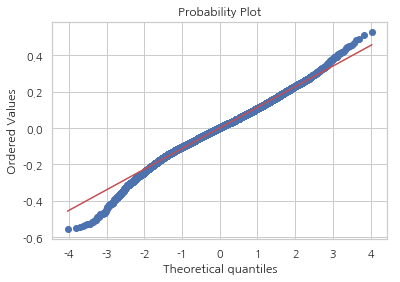

In [13]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [14]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 587.942
P-value     :  0.000


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

In [15]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

/home/dockeruser/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


KeyboardInterrupt: 

# 6. Cross Validation

In [16]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

KeyboardInterrupt: 

In [ ]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('./data/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

PatsyError: Error converting data to categorical: observation with value 'Vostochnoe' does not match any of the expected levels (expected: ['Ajeroport', 'Akademicheskoe', ..., 'Zjablikovo', 'Zjuzino'])
    np.log(_price_doc) ~ C(_radiation_raion) + C(_product_type) + C(_sub_area) + C(_sub_area) + C(_sub_area) + C(_sub_area) + C(_sub_area) + C(_culture_objects_top_25) + C(_railroad_1line) + scale(np.log(_usdrub)) + scale(_floor) + scale(_state) + scale(np.log(_healthcare_centers_raion)) + scale(np.log(_university_top_20_raion)) + scale(np.log(_public_transport_station_min_walk)) + scale(np.log(_additional_education_km)) + scale(np.log(_big_church_km)) + scale(np.log(_cafe_count_1000_price_high)) + scale(np.log(_mosque_count_1500)) + scale(np.log(_trc_count_2000)) + scale(_trc_sqm_5000) + scale(_market_count_5000) + scale(I(np.log(_full_sq) ** 2)) + scale(I(_floor ** 2)) + scale(I(np.log(_kitch_sq) ** 2)) + scale(I(_state ** 2)) + scale(I(np.log(_area_m) ** 2)) + scale(I(np.log(_sport_objects_raion) ** 2)) + scale(I(np.log(_office_raion) ** 2)) + scale(I(np.log(_build_count_brick) ** 2)) + scale(I(np.log(_hospice_morgue_km) ** 2)) + scale(I(np.log(_big_church_km) ** 2)) + scale(I(np.log(_cafe_count_1000_na_price) ** 2)) + scale(I(np.log(_cafe_count_1000_price_high) ** 2)) + scale(I(np.log(_cafe_count_1500_price_high) ** 2)) + scale(I(np.log(_avg_price_ID_metro) ** 2))
                                                                  ^^^^^^^^^^^^

## Score

0.39643